In [1]:
import numpy as np
import pandas as pd
import keras
import statsmodels.api as sm
from scipy.optimize import minimize

In [2]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n) # Initial guess: equally weighted portfolio
    bounds = ((0, 1.0),) * n #  # Bounds for weights: between 0 and 1. an N-tuple of 2-tuples
    # Construct the constraint: weights must sum to 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = weights.T @ er # Portfolio return
        vol = (weights.T @ cov @ weights)**0.5 # Portfolio volatility
        return -(r - riskfree_rate)/vol # Negative Sharpe ratio
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=252)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=252)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=252)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period # Excess returns over the risk-free rate
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year) # Annualized excess return
    ann_vol = annualize_vol(r, periods_per_year) # Annualized volatility
    return ann_ex_ret/ann_vol # Annualized Sharpe ratio

In [3]:
tickers = ['AAPL','NVDA','MSFT','LLY','DVA','COR','JPM','BAC','WFC',"AMZN", "NKE", "SBUX","GOOGL", "META", "VZ","BA", "MMM", "GE","PG", "KO", "PEP","XOM", "CVX", "SLB","NEE", "DUK", "SO","AMT", "SPG", "PLD","BHP", "RIO", "ECL"]
data = pd.read_csv('Data/merged.csv', index_col = 0)
data.head()

,AAPL,AMT,AMZN,BA,BAC,BHP,COR,CVX,DUK,DVA,...,PG_bl,PLD_bl,RIO_bl,SBUX_bl,SLB_bl,SO_bl,SPG_bl,VZ_bl,WFC_bl,XOM_bl
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-27,0.003098,-0.004712,0.002866,0.020315,0.008194,-0.003671,-0.013465,0.001167,0.004500,-0.018452,...,84.384505,60.180218,32.819811,60.759566,37.267593,38.387174,133.592358,40.678132,41.342251,55.318263
2019-02-28,-0.009836,0.017032,-0.000768,0.010380,-0.010211,-0.025424,0.006160,-0.004164,0.004256,-0.000351,...,85.165728,60.498095,32.976219,61.012039,37.249433,38.570166,133.809597,40.708327,41.328620,55.855836
2019-03-01,0.010511,0.010048,0.019453,0.001500,0.007909,-0.007372,-0.003842,0.020488,-0.001450,0.002636,...,85.474682,60.627424,33.025418,61.299502,37.288458,38.633556,132.923216,40.676481,41.320874,56.233549
2019-03-04,0.005029,0.009948,0.014620,-0.017997,-0.009553,0.005332,-0.030128,0.000738,0.003909,-0.028221,...,85.618214,60.762880,33.106702,61.649085,37.303158,38.728930,132.505011,40.727640,41.318066,56.270579
2019-03-05,-0.001820,0.007624,-0.002205,-0.005940,0.001722,0.001894,-0.010189,0.009581,-0.003894,-0.042208,...,85.691880,60.860296,33.125684,62.243301,37.331114,38.832481,132.014307,40.845858,41.326191,56.521465


In [4]:
data.tail()

,AAPL,AMT,AMZN,BA,BAC,BHP,COR,CVX,DUK,DVA,...,PG_bl,PLD_bl,RIO_bl,SBUX_bl,SLB_bl,SO_bl,SPG_bl,VZ_bl,WFC_bl,XOM_bl
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-25,-0.001697,0.017534,0.005610,-0.057208,0.012432,-0.007560,0.006716,0.025186,0.012587,0.028432,...,143.180758,123.590612,63.677516,90.413680,46.907322,67.003606,137.544371,36.054594,46.248249,94.586764
2024-01-26,-0.009013,-0.014585,0.008685,0.017783,0.001198,0.004214,-0.005301,0.003837,0.001462,-0.002420,...,143.021841,123.264666,63.790200,90.449849,46.918339,66.963430,137.472308,36.211315,46.200025,94.490834
2024-01-29,-0.003586,0.009225,0.013449,-0.001363,0.005384,0.000000,0.003491,-0.000402,-0.001043,0.010637,...,143.190843,123.302445,63.943230,90.697166,46.840670,66.868427,137.411745,36.480338,46.157634,94.400190
2024-01-30,-0.019246,-0.017829,-0.014015,-0.023149,0.035109,-0.003066,0.009568,0.006976,-0.002506,-0.007294,...,143.218392,123.030460,64.106458,91.067634,46.732766,66.787620,136.939643,36.742786,46.037166,94.163409
2024-01-31,-0.019358,0.000460,-0.023899,0.052884,-0.022420,-0.008904,0.055094,-0.017919,0.003140,0.005952,...,143.169070,123.059018,64.250564,91.064598,46.560602,66.720728,136.378099,36.866211,46.025567,94.143095


In [5]:
data_train = data[data.index <= '2023-02-03']
data_test = data[data.index > '2023-02-03']

estimation_window = 22
n_periods = data_test.shape[0]
windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]

In [6]:
returns = pd.read_csv('Data/stock_5y_returns.csv', index_col = 0)
returns = returns[tickers]
target = returns.shift(-1)

# Load Predicted Returns

Uncomment A/B for results using all features/fama french 3 factors only

In [33]:
# A: all features
'''
predicted_returns_lr = pd.read_csv('Predicted Returns/predicted_returns_lr.csv')
predicted_returns_lr.set_index('Date', inplace = True)
predicted_returns_rf = pd.read_csv('Predicted Returns/predicted_returns_rf.csv')
predicted_returns_rf.set_index('Date', inplace = True)
predicted_returns_tree = pd.read_csv('Predicted Returns/predicted_returns_tree.csv')
predicted_returns_tree.set_index('Date', inplace = True)
predicted_returns_nn = pd.read_csv('Predicted Returns/predicted_returns_nn.csv')
predicted_returns_nn.set_index('Date', inplace = True)
'''
# B: farma french 3 factors only

predicted_returns_lr = pd.read_csv('Predicted Returns/predicted_returns_lr_ff_only.csv')
predicted_returns_lr.set_index('Date', inplace = True)
predicted_returns_rf = pd.read_csv('Predicted Returns/predicted_returns_rf_ff_only.csv')
predicted_returns_rf.set_index('Date', inplace = True)
predicted_returns_tree = pd.read_csv('Predicted Returns/predicted_returns_tree_ff_only.csv')
predicted_returns_tree.set_index('Date', inplace = True)
predicted_returns_nn = pd.read_csv('Predicted Returns/predicted_returns_nn_ff_only.csv')
predicted_returns_nn.set_index('Date', inplace = True)


# LR

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Sample Return,0.751990,0.396030,1.770201,-0.211424
Linear Regression,1.461447,0.422975,3.286193,-0.200904


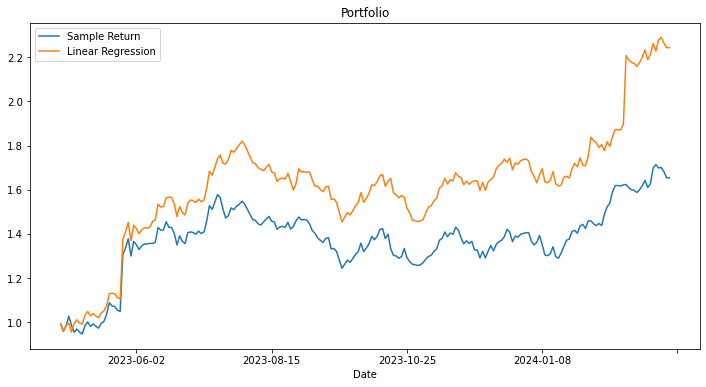

In [34]:
rf = 0.03
weights_sample = [msr(rf, returns.iloc[win[0]:win[1]].mean(), returns.iloc[win[0]:win[1]].cov()) for win in windows]
weights_sample = pd.DataFrame(weights_sample, index=returns[-len(windows):].index, columns=returns.columns)
opt_sample = (weights_sample * returns[-len(predicted_returns_lr.dropna()):]).sum(axis="columns",  min_count=1)


weights_LR = [msr(rf, predicted_returns_lr.iloc[win[1]], returns.iloc[win[0]:win[1]].cov()) for win in windows]
weights_LR = pd.DataFrame(weights_LR, index=returns[-len(windows):].index, columns=predicted_returns_lr.columns)
opt_LR = (weights_LR * returns[-len(predicted_returns_lr.dropna()):]).sum(axis="columns",  min_count=1)
btr = pd.DataFrame({"Sample Return": opt_sample, "Linear Regression": opt_LR})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio")
summary_stats(btr.dropna())

# RF

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Sample Return,0.751990,0.396030,1.770201,-0.211424
Random Forest,2.023832,0.416649,4.646844,-0.136019


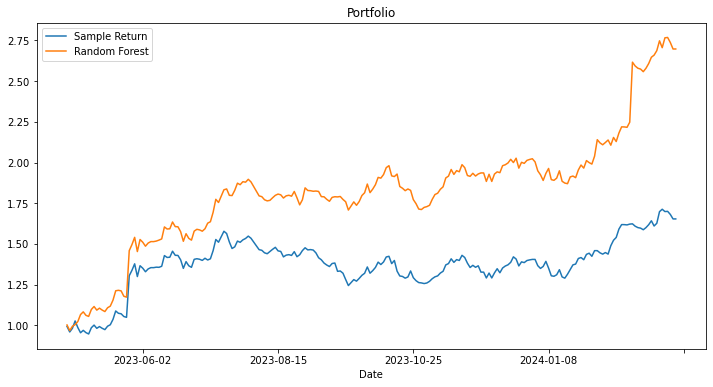

In [35]:
weights_rf = [msr(rf, predicted_returns_rf.iloc[win[1]], returns.iloc[win[0]:win[1]].cov()) for win in windows]
weights_rf = pd.DataFrame(weights_rf, index=returns[-len(windows):].index, columns=predicted_returns_rf.columns)
opt_rf = (weights_rf * returns[-len(predicted_returns_rf.dropna()):]).sum(axis="columns",  min_count=1)
btr = pd.DataFrame({"Sample Return": opt_sample, "Random Forest": opt_rf})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio")
summary_stats(btr.dropna())

# Tree

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Sample Return,0.751990,0.396030,1.770201,-0.211424
Tree,1.927393,0.417189,4.416348,-0.164301


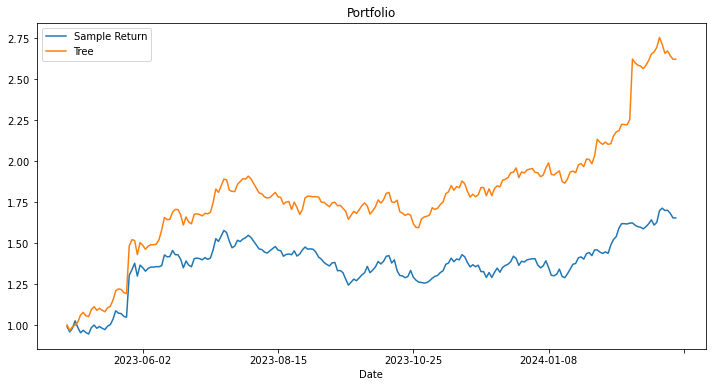

In [36]:
weights_tree = [msr(rf, predicted_returns_tree.iloc[win[1]], returns.iloc[win[0]:win[1]].cov()) for win in windows]
weights_tree = pd.DataFrame(weights_tree, index=returns[-len(windows):].index, columns=predicted_returns_tree.columns)
opt_tree = (weights_tree * returns[-len(predicted_returns_tree.dropna()):]).sum(axis="columns",  min_count=1)
btr = pd.DataFrame({"Sample Return": opt_sample, "Tree": opt_tree})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio")
summary_stats(btr.dropna())

# NN

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Sample Return,0.751990,0.396030,1.770201,-0.211424
Neural Network,1.277843,0.345005,3.512092,-0.089275


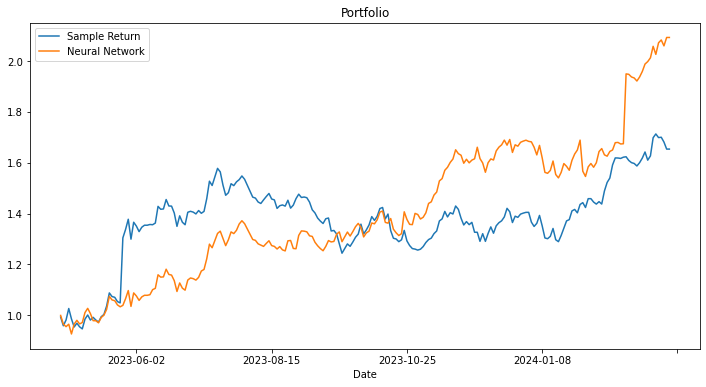

In [37]:
weights_nn = [msr(rf, predicted_returns_nn.iloc[win[1]], returns.iloc[win[0]:win[1]].cov()) for win in windows]
weights_nn = pd.DataFrame(weights_nn, index=returns[-len(windows):].index, columns=predicted_returns_nn.columns)
opt_nn = (weights_nn * returns[-len(predicted_returns_nn.dropna()):]).sum(axis="columns",  min_count=1)
btr = pd.DataFrame({"Sample Return": opt_sample, "Neural Network": opt_nn})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio")
summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Sample Return,0.751990,0.396030,1.770201,-0.211424
Neural Network,1.277843,0.345005,3.512092,-0.089275
Tree,1.927393,0.417189,4.416348,-0.164301
Random Forest,2.023832,0.416649,4.646844,-0.136019
Linear Regression,1.461447,0.422975,3.286193,-0.200904


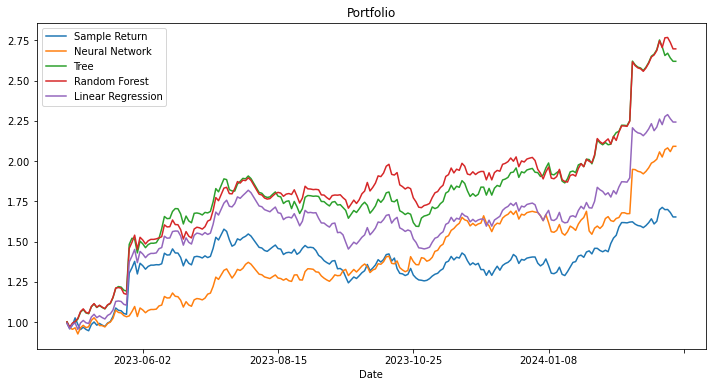

In [38]:
btr = pd.DataFrame({"Sample Return": opt_sample, "Neural Network": opt_nn, "Tree": opt_tree,"Random Forest": opt_rf,"Linear Regression": opt_LR})
(1+btr).cumprod().plot(figsize=(12,6), title="Portfolio")
summary_stats(btr.dropna())